In [1]:
import sys
sys.path.append('..')


from models.backbone_R2U_Net import build_backbone
from models.TopDiG import build_TopDiG
from dataloader_cocostyle import image_graph_collate_road_network_coco, min_max_normalize
from dataloader_cocostyle import CrowdAI

from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import yaml
import json
import torch
import numpy as np

class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Built Dataset Options:
--Num.of images: 1355
--Gap Distance: 10 --Sigma: 1.0 --nms: False
torch.Size([6, 3, 320, 320])
0.97726715 0.0


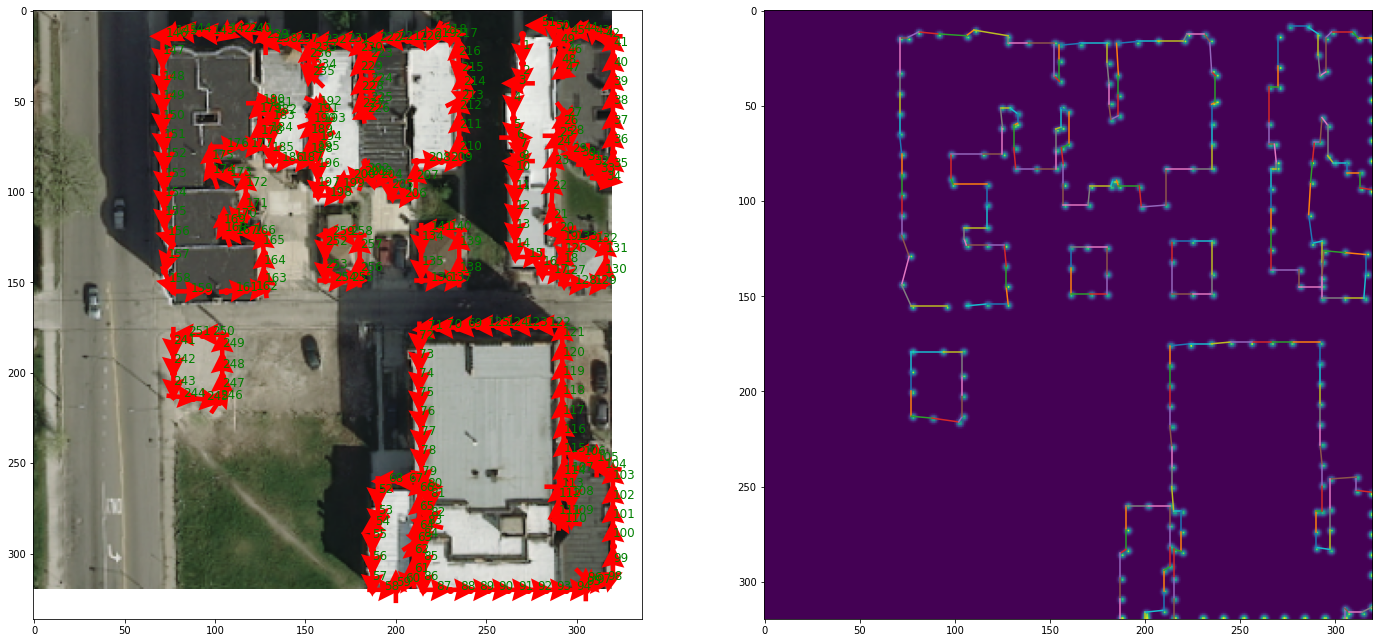

In [2]:
dataset = CrowdAI(images_directory='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_inria_test/images',
                    annotations_path='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_inria_test/annotation.json',)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, collate_fn=image_graph_collate_road_network_coco, shuffle=False)

print(next(iter(dataloader))[0].shape) # image
ld = iter(dataloader)

data = next(iter(dataloader))

image = data[0][0].detach().cpu().numpy().transpose(1,2,0)
heatmap = data[1][0].detach().cpu().numpy()[0]
gt_nodes = data[2][0].detach().cpu().numpy() * image.shape[0]
edges = data[3][0].detach().cpu().numpy()

gt_nodes = gt_nodes.astype('int64')

print(heatmap.max(), heatmap.min())

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0))
ax[0].scatter(gt_nodes[:,1], gt_nodes[:,0], color='r')

for idx, e in enumerate(edges):
    if int(idx%160) == 0:
        continue
    else:
        connect = np.stack([gt_nodes[e[0]], gt_nodes[e[1]]], axis=0)

        mid_point = np.mean(connect, axis=0)
        direction = connect[1] - connect[0]
        direction = direction / np.linalg.norm(direction)
        ax[0].quiver(mid_point[1], mid_point[0], direction[1], direction[0], 
                    pivot='mid',
                    angles='xy', scale_units='xy', color='red', headwidth=5, headlength=5)
        
        ax[0].text(mid_point[1], mid_point[0], f'{idx}', color='green', fontsize=12)
        ax[1].plot(connect[:,1], connect[:,0])

ax[1].imshow(heatmap)
plt.show()


In [3]:
config_file = "../configs/topdig/topdig_10_1.0_control_diag.yaml"
config_file = "../configs/topdig/topdig_10_1.0_control_nearest_diag.yaml"
config_file = "../configs/topdig/topdig_10_1.0_control_nearest_nearest.yaml"
config_file2 = '../configs/pretrain/pretrain_10_1.0_control.yaml'

ckpt_backbone_path = '../work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_control_10/models/epochs_130.pth'
# ckpt_path = '../work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_topdig_10_1.0_control_hungarian_diag_ccw_10/models/epochs_20.pth'
ckpt_path = "../work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_topdig_10_1.0_control_nearest_diag_10/models/epochs_20.pth"
ckpt_path = "../work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_topdig_10_1.0_control_nearest_nearest_10/models/epochs_15.pth"

with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)

with open(config_file2) as f:
    config2 = yaml.load(f, Loader=yaml.FullLoader)
config2 = dict2obj(config2)

model = build_TopDiG(config) # 빌드 함수 내부에서 ckpt 파일 로드함

checkpoint = torch.load(ckpt_backbone_path, map_location='cpu')
print(checkpoint['model_state_dict'].keys())
print(model.state_dict().keys())

checkpoint2 = torch.load(ckpt_path, map_location='cpu')
missing_keys, unexpected_keys = model.load_state_dict(checkpoint2['model_state_dict'], strict=False) # 여기서 TopDiG 학습한 체크포인트 로드
unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
if len(missing_keys) > 0:
    print('Missing Keys: {}'.format(missing_keys))
if len(unexpected_keys) > 0:
    print('Unexpected Keys: {}'.format(unexpected_keys))
# model.eval()
device = torch.device("cuda")
model = model.to(device)

odict_keys(['encoder.RRCNN1.RCNN.0.conv.0.weight', 'encoder.RRCNN1.RCNN.0.conv.0.bias', 'encoder.RRCNN1.RCNN.0.conv.1.weight', 'encoder.RRCNN1.RCNN.0.conv.1.bias', 'encoder.RRCNN1.RCNN.0.conv.1.running_mean', 'encoder.RRCNN1.RCNN.0.conv.1.running_var', 'encoder.RRCNN1.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN1.RCNN.1.conv.0.weight', 'encoder.RRCNN1.RCNN.1.conv.0.bias', 'encoder.RRCNN1.RCNN.1.conv.1.weight', 'encoder.RRCNN1.RCNN.1.conv.1.bias', 'encoder.RRCNN1.RCNN.1.conv.1.running_mean', 'encoder.RRCNN1.RCNN.1.conv.1.running_var', 'encoder.RRCNN1.RCNN.1.conv.1.num_batches_tracked', 'encoder.RRCNN1.Conv_1x1.weight', 'encoder.RRCNN1.Conv_1x1.bias', 'encoder.RRCNN2.RCNN.0.conv.0.weight', 'encoder.RRCNN2.RCNN.0.conv.0.bias', 'encoder.RRCNN2.RCNN.0.conv.1.weight', 'encoder.RRCNN2.RCNN.0.conv.1.bias', 'encoder.RRCNN2.RCNN.0.conv.1.running_mean', 'encoder.RRCNN2.RCNN.0.conv.1.running_var', 'encoder.RRCNN2.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN2.RCNN.1.conv.0.weight', 'enc

In [4]:
images = torch.zeros((6,3,320,320)).to(device)
for i, image in enumerate(data[0]):
    image = resize(image, (3, 320, 320), anti_aliasing=True, preserve_range=True)
    images[i] = torch.tensor(image).to(device)
with torch.no_grad():
    out = model(images)
scores1, scores2 = out['scores1'], out['scores2']
htm_TopDiG, nms_TopDiG = out['pred_heatmaps'], (out['pred_nodes']*320)
nms_TopDiG = nms_TopDiG.type(torch.int)
print(htm_TopDiG[1].unique())
print(nms_TopDiG[1][:10])

tensor([-20.7396, -20.3077, -19.9787,  ...,   4.6305,   4.6769,   4.7069],
       device='cuda:0')
tensor([[138,  28],
        [148,  28],
        [ 88,   0],
        [ 97, 190],
        [ 79,   0],
        [148,  49],
        [126,  28],
        [148,  39],
        [ 18,   0],
        [ 24, 222]], device='cuda:0', dtype=torch.int32)


In [5]:
from scipy.optimize import linear_sum_assignment # Scipy에 구현된 헝가리안 알고리즘 사용

def scores_to_permutations(scores): # 인퍼런스용 함수
    """
    Input a batched array of scores and returns the hungarian optimized 
    permutation matrices.
    """
    B, N, N = scores.shape

    scores = scores.detach().cpu().numpy()
    perm = np.zeros_like(scores)
    for b in range(B):
        # sinkhorn 알고리즘은 비공개된 트레인 파일에 있을 듯
        # 반복적인 노멀라이제이션(100번)을 위해 싱크홀 알고리즘 사용
        # 인퍼런스시에 헝가리안 알고리즘으로 linear sum assignment result 뽑는다
        r, c = linear_sum_assignment(-scores[b]) # 점수가 높을 수록 페어일 확률이 높으므로 -를 붙여서 최소 찾는 문제로 바꾼다.
        perm[b,r,c] = 1 # 헝가리안 알고리즘이 찾은 칸은 1로 아니면 0인 permutation matrix (B N N) 만든다
    return torch.tensor(perm) # 텐서로 바꿔주기

예측 노드 수: 256
선택된 예측 노드 수: 168
정답 노드 수: 170


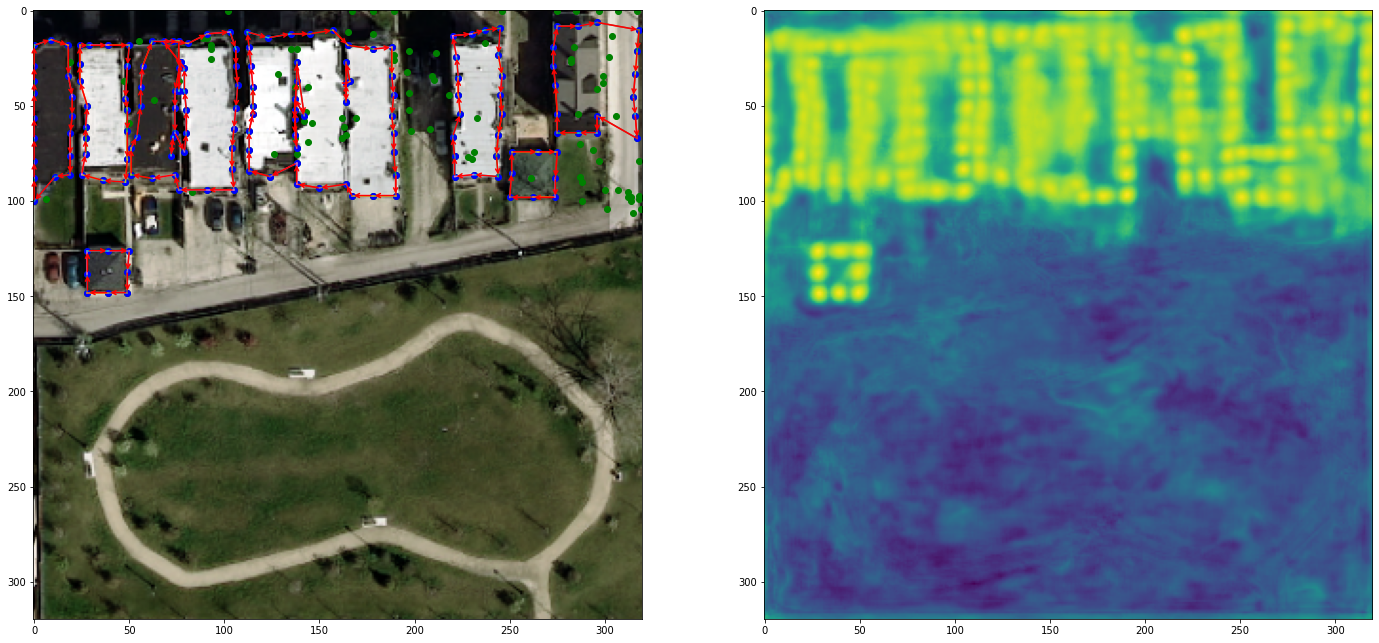

In [9]:
idx_of_batch = 1

scores = scores1.sigmoid() + scores2.transpose(1,2).sigmoid()

permu = scores_to_permutations(scores)
mat = permu[idx_of_batch].numpy()
edges = []
for i in range(len(mat)):
    for j in range(len(mat)):
        if mat[i][j] == 1:
            if i != j:
                edges.append((i,j))
nodes = nms_TopDiG[idx_of_batch].detach().cpu().numpy()
image = images[idx_of_batch].detach().cpu().numpy().transpose(1,2,0)

print("예측 노드 수:", len(nodes))
print("선택된 예측 노드 수:", len(edges))
print("정답 노드 수:", len(data[2][1].detach().cpu().numpy()))

# Visualize
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0.5))
ax[1].imshow(htm_TopDiG[idx_of_batch,0].detach().cpu().numpy())
ax[0].scatter(nodes[:,1], nodes[:,0], color='g')
for x, _ in edges:
    ax[0].scatter(nodes[x][1], nodes[x][0], color='b')
for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    ax[0].plot(connect[:,1], connect[:,0])
    ax[0].annotate("", xy=nodes[e[0]][::-1], xytext=nodes[e[1]][::-1], 
                arrowprops=dict(arrowstyle="->", lw=1.5, color='r'))

plt.show()

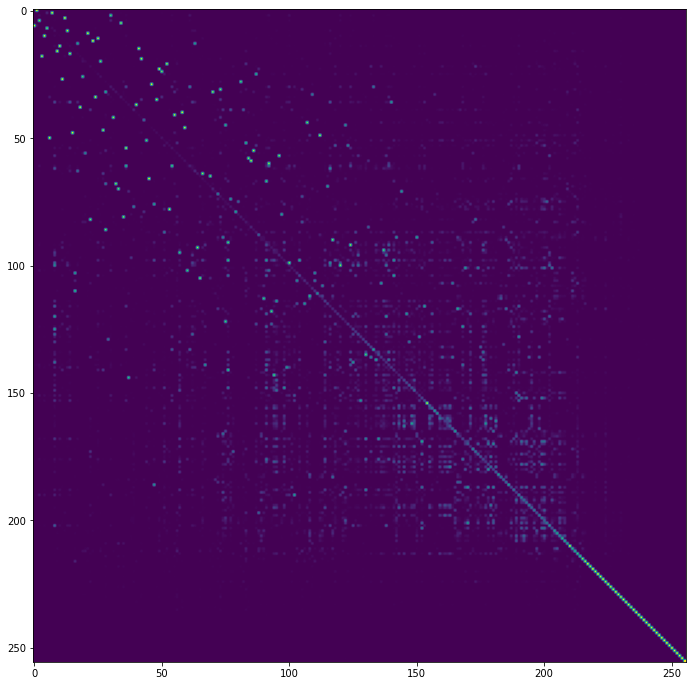

In [10]:
plt.figure(figsize=(12,12))
plt.imshow(scores1.sigmoid().detach().cpu().numpy()[idx_of_batch])